# First Steps with Huggingface


In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

Try to avoid 'pip install' in the notebook. This can destroy dependencies in the env.

In [33]:
# only running this cell leads to problems when kernel has not been restarted
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.ops import dataset_ops
from tensorboard.backend.event_processing import event_accumulator
from absl import logging
from datetime import datetime
import os
import shutil
import numpy as np
from tqdm import tqdm
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


#from transformers import *
from transformers import (BertTokenizer,
                          TFBertForSequenceClassification,
                          TFBertModel,
                          TFBertForPreTraining,
                          glue_convert_examples_to_features,
                          glue_processors,)

# local packages
import preprocessing.preprocessing as pp
import utils.model_metrics  as model_metrics
import importlib
importlib.reload(pp);

### To Do: 
- put preprocessing concerning special characters into the convert_to_glue function (?)
- extend to other language models like gpt-2
- find out how to attach additional layers to the architecture
- find out at which point multilingualism can be introduced


## Define Paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')

missing PATH_TENSORBOARD


In [4]:
print(data_dir)

/home/vera_luechinger/data


## 1. Loading the IMDb Dataset from Tensorflow

In [5]:
train_data, validation_data, test_data = tfds.load(name="imdb_reviews",
                                                   data_dir=data_dir,
                                                   split=('train[:60%]', 'train[60%:]', 'test'),
                                                   as_supervised=True)

# trying to extract the info requires loading the data without splitting it
data, data_info = tfds.load(name="imdb_reviews",
                            data_dir=data_dir,
                            as_supervised=True,
                            with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0


## 2. Data Preprocessing

### 2.1. Info about the Data

In [6]:
#pp.print_info_data(data['train'],print_example=False)

In [7]:
data_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

### 2.2. Cleaning

The data still contains non-word structures like \<br />\<br />  and \\ which have to be removed.

In [8]:
#np.array(list(data_ex['train'].as_numpy_iterator()))
for line in np.array(list(train_data.as_numpy_iterator())):
    print(line[0].decode("utf-8"))#.lower())
    break

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [9]:
def preprocess_reviews(reviews):
    #REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    #reviews = [REPLACE_NO_SPACE.sub("", line[0].decode("utf-8").lower()) for line in np.array(list(reviews.as_numpy_iterator()))]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line[0].decode("utf-8")) for line in np.array(list(reviews.as_numpy_iterator()))]# for line in reviews]
    
    return reviews

In [10]:
reviews_train_clean = preprocess_reviews(train_data)
reviews_valid_clean = preprocess_reviews(validation_data)
type(reviews_valid_clean[0])

str

In [11]:
# just for testing the code below
reviews_train_clean_encoded = [line.encode("utf-8") for line in reviews_train_clean]
reviews_valid_clean_encoded = [line.encode("utf-8") for line in reviews_valid_clean]
type(reviews_valid_clean_encoded[0])

bytes

In [12]:
labels_train = [int(line[1].decode("utf-8")) for line in np.array(list(train_data.as_numpy_iterator()))]
labels_valid = [int(line[1].decode("utf-8")) for line in np.array(list(validation_data.as_numpy_iterator()))]
type(labels_train[0])

int

In [13]:
labels_train_encoded = [repr(line).encode("utf-8") for line in labels_train]
labels_valid_encoded = [repr(line).encode("utf-8") for line in labels_valid]

In [14]:
for index, entry in enumerate(reviews_train_clean):
    if index < 10:
        print(entry)
    else:
        break

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

### 2.3. Converting the Data to the Right Structure



In [15]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [16]:
train_data_np = pp.convert_np_array_to_glue_format(reviews_train_clean, labels_train)
valid_data_np = pp.convert_np_array_to_glue_format(reviews_valid_clean, labels_train, shift=len(list(train_data_np)))

In [17]:
# this may not work well for big datasets => use with caution
len(list(train_data_np))

15000

In [18]:
train_data_np2 = pp.convert_np_array_to_glue_format(reviews_train_clean_encoded, labels_train_encoded, decode=True)
valid_data_np2 = pp.convert_np_array_to_glue_format(reviews_valid_clean_encoded, labels_train_encoded, decode=True, shift=len(list(train_data_np2)))

In [19]:
train_data_glue = pp.convert_tf_data_to_glue_format(data['train'])
valid_data_glue = pp.convert_tf_data_to_glue_format(data['test'],shift=len(list(train_data_glue)))

## 3. Experimenting with Tokenizer

### 3.1. Defining the Tokenizer Parameters

In [20]:
pretrained_weights = 'bert-base-cased'

In [21]:
# try out also different weights
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)


In [22]:
# code from https://github.com/strongio/keras-bert/blob/master/keras-bert.py
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label


# changed this to fit the input data better
def convert_text_to_examples(data):
    """Create InputExamples"""
    InputExamples = []
    for data in data:
        InputExamples.append(
            # need to access only the text here
            #InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples


def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

### GLUE


In [23]:
train_dataset = glue_convert_examples_to_features(train_data_glue, tokenizer, max_length=256, task='sst-2')
validation_dataset = glue_convert_examples_to_features(valid_data_glue, tokenizer, max_length=256, task='sst-2')

## Building the Model

In [24]:
model = TFBertForSequenceClassification.from_pretrained(pretrained_weights)

In [25]:
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
validation_dataset = validation_dataset.batch(64)

In [26]:
num_train_batches = 25000/32
num_valid_batches = 25000/64
print(num_train_batches, num_valid_batches)

781.25 390.625


In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
bert_history = model.fit(train_dataset, 
                              epochs=2, 
                              steps_per_epoch=10, 
                              verbose=1,
                              validation_data=validation_dataset, 
                              validation_steps=10
                              )

Train for 10 steps, validate for 10 steps
Epoch 1/2
10/10 [==============================] - 586s 59s/step - loss: 0.6890 - accuracy: 0.5562 - val_loss: 0.6809 - val_accuracy: 0.5422
Epoch 2/2
10/10 [==============================] - 537s 54s/step - loss: 0.6744 - accuracy: 0.6000 - val_loss: 0.5951 - val_accuracy: 0.7859


## Visualization

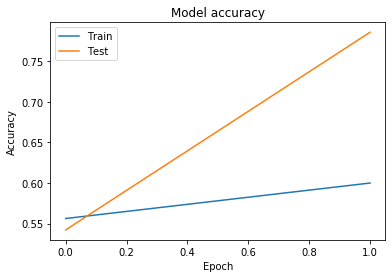

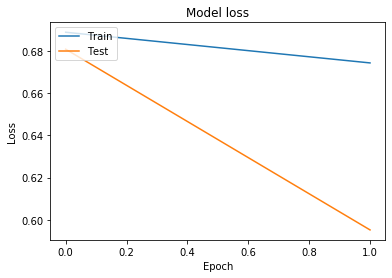

In [31]:
# Plot training & validation accuracy values
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
sns.heatmap(confusion_matrix(true_index, predict_index), 
            annot=True, cbar=False, fmt='d')#, ax=ax)

NameError: name 'true_index' is not defined